# A Bird Recommender System Using KNN

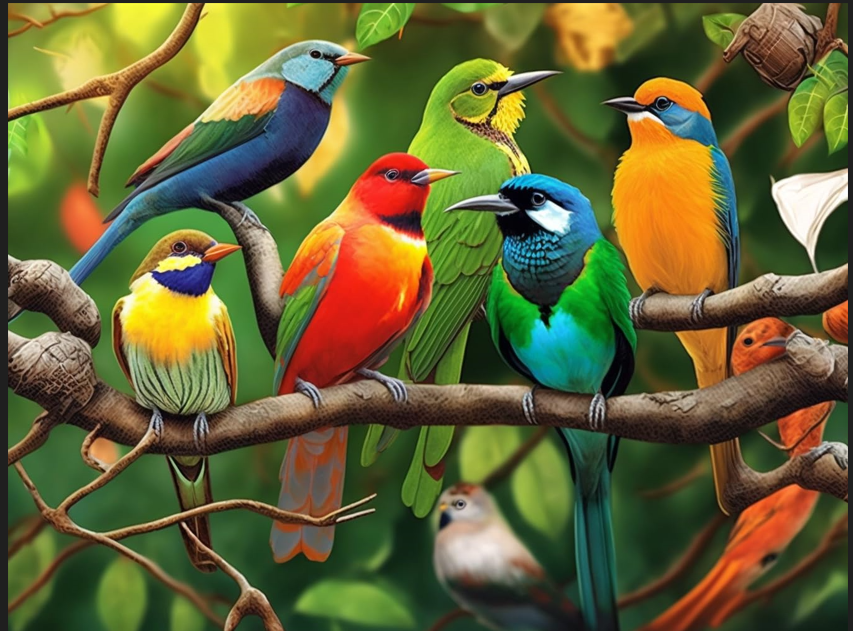





## Introduction


eBird is the world's largest citizen science project. To date, more than 1 billion bird observations have been tallied across nearly 100 million checklists submitted by nearly 750,000 citizen scientists across the globe, documenting over 99% of the bird species known to exist today.

The main challenge is ensuring the data is accurate and complete. Often, citizen scientists forget about some species they observed in the field when submitting their checklist, which leads to missing data.

Our goal as a team is to utilize the **K-Nearest Neighbor** model to recommend species of birds that are most likely to be observed next given any checklist, so that citizen scientists in the field can double-check that their checklists not missing any species that they observed but forgot to record.

#### Data:
**training_set.csv**:
The training set is a matrix of bird species in rows, checklists in columns, and number of birds recorded on a checklist as values. Zeros are true zeros because the species was not detected at the time of checklist submission.

**test_set.csv**:
The test set a matrix of additional checklists containing the same bird species in rows as the training set. However, unlike the training set, each test checklist contains exactly 5 values that have been set to zero that were not zero in the submitted checklist.



## Approach


Our stepwise approach in ensuring our recommender system works accurately is as follows:
1. Data pre-processing.
2. Building an algorithm for the k-NN recommender function.
3. Using a cross validation approach on the training data to search for best k-value that reduces the MAE(Mean Absolute Error) the most.
4. Use the best k-value to make recommendations.
5. Uploading our recommendations in the required format for the MAE results.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Data Pre-processing

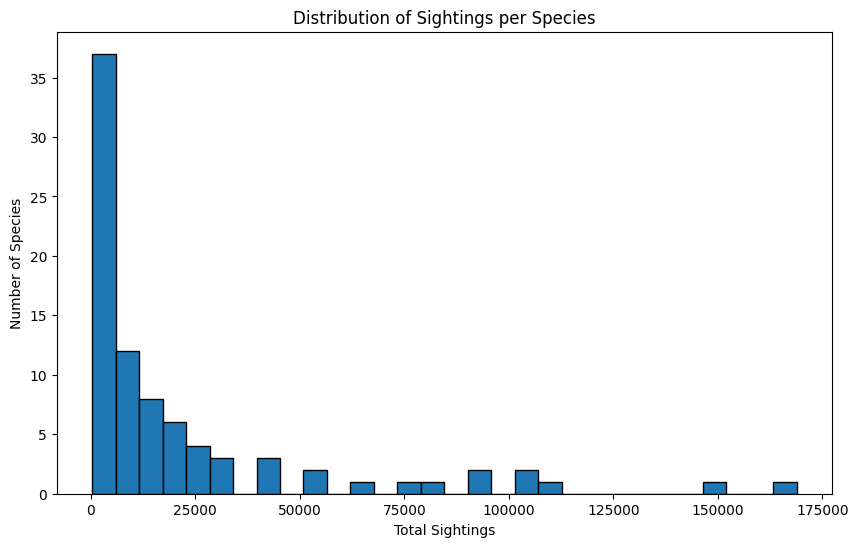

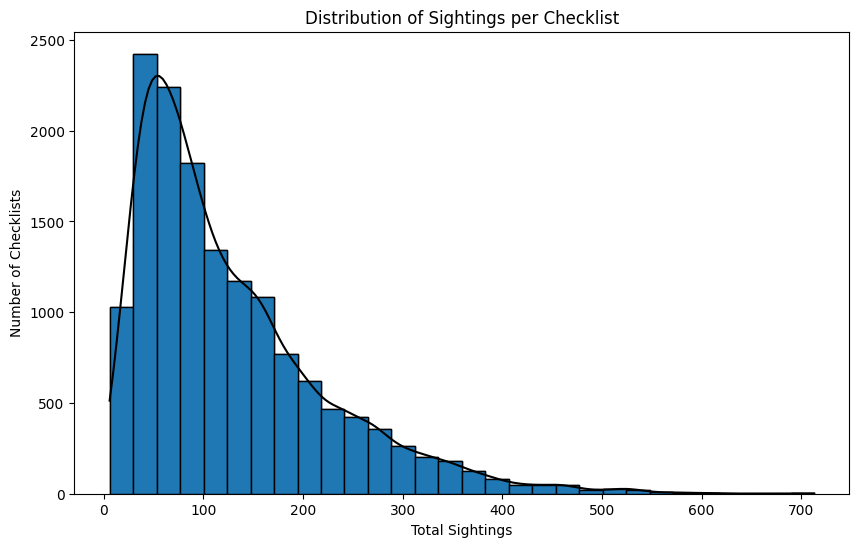

In [ ]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load the datasets
training_set = pd.read_csv('/content/drive/MyDrive/CIS_678/Challenge_01/training_set.csv', index_col=0)

# Histogram of the number of sightings per species
# Summing across columns (axis=1) gives the total sightings per species
species_sightings = training_set.sum(axis=1)
plt.figure(figsize=(10, 6))
plt.hist(species_sightings, bins=30, edgecolor='black')
plt.title('Distribution of Sightings per Species')
plt.xlabel('Total Sightings')
plt.ylabel('Number of Species')
plt.show()

# Histogram of the number of sightings per checklist
# Summing across rows (axis=0) gives the total sightings per checklist
checklist_sightings = training_set.sum(axis=0)
plt.figure(figsize=(10, 6))
sns.histplot(checklist_sightings, bins=30, kde=True, color='black', edgecolor='black')
plt.hist(checklist_sightings, bins=30, edgecolor='black')
plt.title('Distribution of Sightings per Checklist')
plt.xlabel('Total Sightings')
plt.ylabel('Number of Checklists')
plt.show()


As we can see from the plots that the data is right skewed, and there are outliers in both the plots.

The first plot shows that there are many species with a few sightings and a small number of species with a very high number of sightings.
A significant number of species have less than 25,000 total sightings, and the frequency drops dramatically beyond this point.
The distribution has a long tail, suggesting that there are a few species with an exceptionally high number of sightings. These could be very common species or those that are easy to spot and identify.

Second plot indicate that most checklists have a small number of total sightings, while fewer checklists have a large number of sightings. The number of checklists decreases sharply as the number of sightings per checklist increases, showing that it's less common for a checklist to have a very high number of sightings.

In [ ]:
import numpy as np
import pandas as pd

# Assuming 'training_set' is your loaded dataset
species_sightings = training_set.sum(axis=1)

# Apply log transformation
species_sightings_log_transformed = np.log1p(species_sightings)

# Similarly, for checklist sightings
checklist_sightings = training_set.sum(axis=0)
checklist_sightings_log_transformed = np.log1p(checklist_sightings)


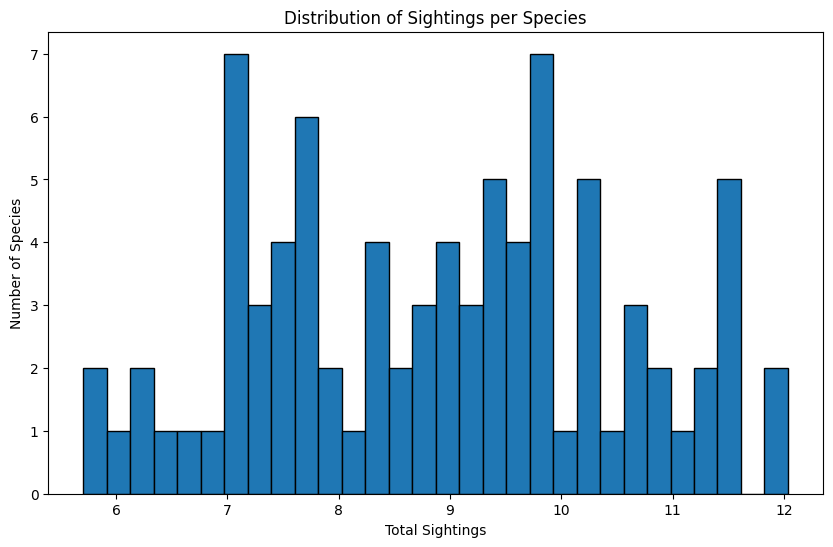

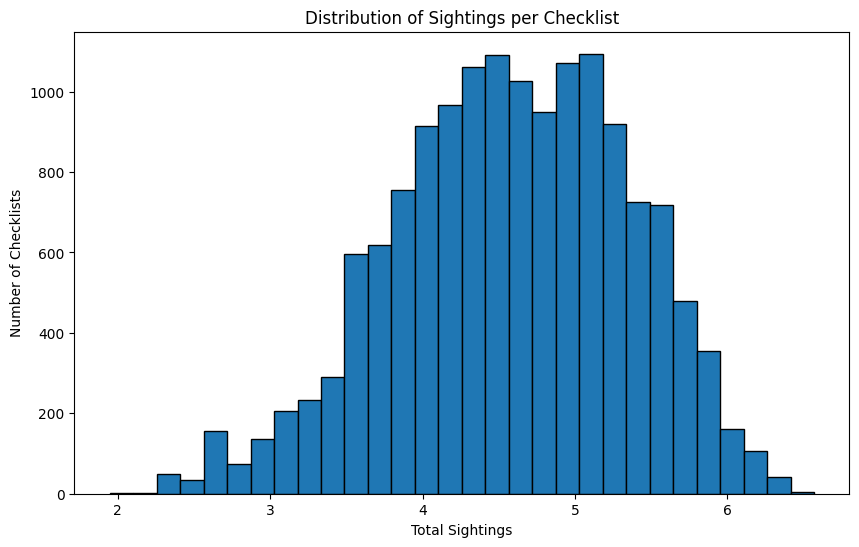

In [ ]:
# Histogram of the number of sightings per species
# Summing across columns (axis=1) gives the total sightings per species

plt.figure(figsize=(10, 6))
plt.hist(species_sightings_log_transformed, bins=30, edgecolor='black')
plt.title('Distribution of Sightings per Species')
plt.xlabel('Total Sightings')
plt.ylabel('Number of Species')
plt.show()

# Histogram of the number of sightings per checklist
# Summing across rows (axis=0) gives the total sightings per checklist

plt.figure(figsize=(10, 6))
plt.hist(checklist_sightings_log_transformed, bins=30, edgecolor='black')
plt.title('Distribution of Sightings per Checklist')
plt.xlabel('Total Sightings')
plt.ylabel('Number of Checklists')
plt.show()


 In the processed dataset, the application of a logarithmic transformation has notably reduced the positive skewness observed in the initial distributions, resulting in more symmetrical and evenly distributed data. This corrective measure has proven effective in mitigating the impact of outliers, thereby rendering the datasets more amenable to statistical methods predicated on the assumption of normality. Consequently, the transformed distributions exhibit a bell-shaped curve characteristic of a normal distribution, facilitating more robust and reliable analysis.

#### Cross Validation
We implemented cross validation to test for the optimum k value for the cosine KNN model for our dataset. From our tests we observed that k=19 was the best k value. However, we were unable to replicate that when we uploaded our submissions on kaggle. On kaggle, k=19 gave us 0.04548 whereas, k=31 gave us 0.04487.



Average MAE for k=5: 0.058529411764705885
Average MAE for k=7: 0.059379084967320264
Average MAE for k=9: 0.05663398692810458
Average MAE for k=11: 0.05967320261437907
Average MAE for k=15: 0.06045751633986927
Average MAE for k=17: 0.060228758169934636
Average MAE for k=19: 0.055751633986928104
Average MAE for k=23: 0.0626797385620915
Average MAE for k=31: 0.06166666666666666
Best k: 19, Best MAE: 0.055751633986928104


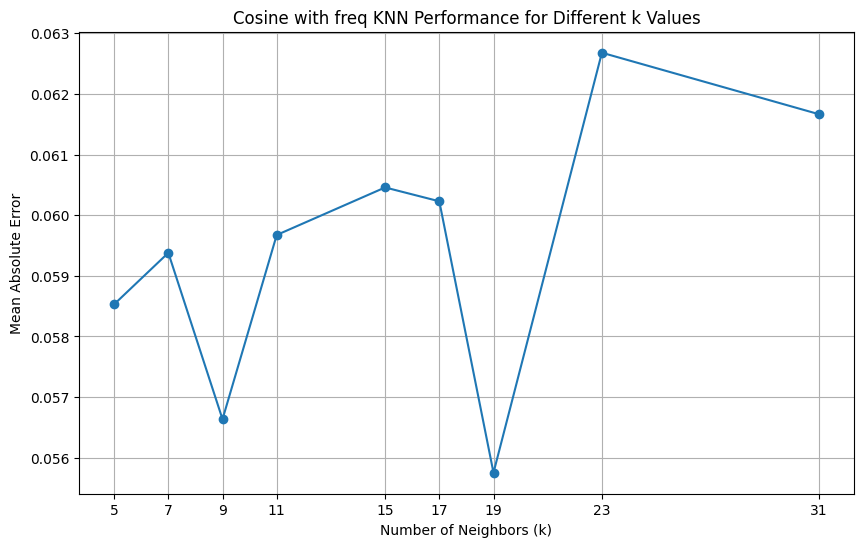

In [ ]:
# Cosine with log transformation

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import random


# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Load the training set
# Read training set and test set
training_set = np.log(pd.read_csv('/content/drive/MyDrive/CIS_678/Challenge_01/training_set.csv', index_col=0) + 1)

# Convert the training set to numpy array and apply log transformation
training_set_log = training_set.to_numpy()

# Define the recommend_by_cosine_nn function
def recommend_by_cosine_nn(A, x, k):
    # Calculate cosine distance between vector x and each column in A
    distances = (np.dot(A.T,x))/(np.sqrt(np.sum(A.T**2,axis=1)*np.sum(x**2)))

    # Select the nearest neighbor based on absolute difference
    training_nn = A[:, np.argsort(-distances)[:k]]
    training_nn = np.mean(training_nn, axis=1)

    # Don't recommend any values which are non-zero in the test sample
    training_nn[x != 0] = 0

    # Generate 5 recommendations
    recommendations = np.zeros(len(x))

    # Select the top 5 non-zeros in "training_nn" that are zero in "x"
    # and set them equal to 1
    top_indices = np.argsort(-training_nn)[:5]
    recommendations[top_indices] = 1

    return recommendations

# Define a function to simulate the test data as described
def simulate_test_data(test_data):
    simulated_data = test_data.copy()
    standard_data = np.zeros_like(test_data)
    for i in range(simulated_data.shape[1]):
        non_zero_indices = np.where(simulated_data[:, i] != 0)[0]
        if len(non_zero_indices) > 5:
            zero_indices = np.random.choice(non_zero_indices, 5, replace=False)
            simulated_data[zero_indices, i] = 0
            standard_data[zero_indices, i] = 1
    return simulated_data, standard_data

# Define the number of folds and k values to test
n_splits = 10
k_values = [5, 7, 9, 11, 15, 17, 19, 23,31,]

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Dictionary to store average MAE for each k
mae_per_k = {}

# Loop over each 'k' value
for k in k_values:
    performances = []

    # Perform K-Fold Cross Validation
    for train_index, val_index in kf.split(training_set_log):
        train_data = training_set_log[:, train_index]
        val_data = training_set_log[:, val_index]

        # Simulate the test data
        simulated_data, standard_data = simulate_test_data(val_data)


        # Apply the KNN model to each sample in simulated_val_data
        predictions = np.apply_along_axis(lambda x: recommend_by_cosine_nn(train_data, x, k), axis=0, arr=simulated_data)

        # Compute the performance metric against the original test data
        mae = mean_absolute_error(standard_data, predictions)
        performances.append(mae)

    # Store the average performance for this k value
    mae_per_k[k] = np.mean(performances)
    print(f'Average MAE for k={k}: {mae_per_k[k]}')

# Find the best k value with the lowest average MAE
best_k = min(mae_per_k, key=mae_per_k.get)
print(f'Best k: {best_k}, Best MAE: {mae_per_k[best_k]}')

# Plotting the MAE results
plt.figure(figsize=(10, 6))
plt.plot(list(mae_per_k.keys()), list(mae_per_k.values()), marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Absolute Error')
plt.title('Cosine with freq KNN Performance for Different k Values')
plt.xticks(k_values)
plt.grid(True)
plt.show()


# Exploring potential correlations

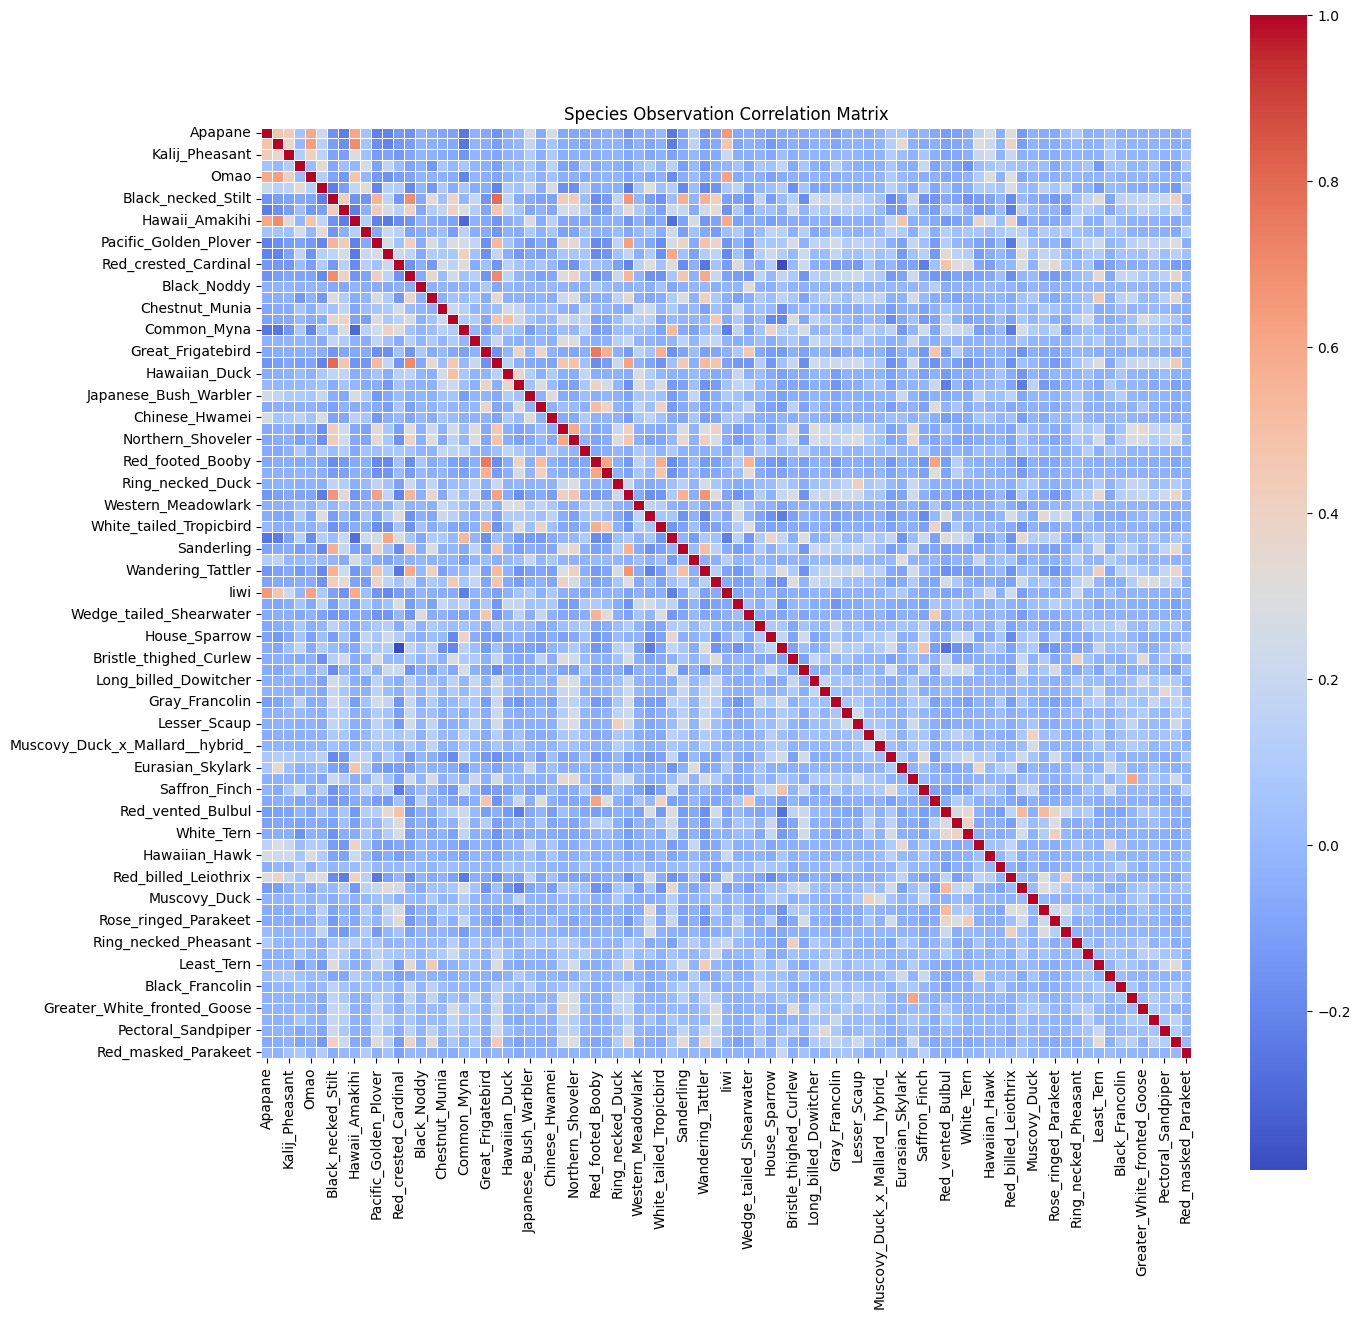

In [ ]:
# Correlation Matrix

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Transpose the DataFrame so that each column represents a species and each row is a checklist
training_set_transposed = training_set.T

# Calculate the correlation matrix
correlation_matrix = training_set_transposed.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix,
            annot=False,      # Turn this to True if you want to see the correlation values
            cmap='coolwarm',  # Choose a color map that you prefer
            linewidths=.5,    # Adjust line widths between cells
            fmt=".2f",        # Formatting for annotation strings
            square=True)      # Make cells square shaped

plt.title('Species Observation Correlation Matrix')
plt.show()

This heatmap represents a Species Observation Correlation Matrix, visualizing the pairwise correlation coefficients between different species based on observations. Each cell within the matrix reflects the strength and direction of the relationship between pairs of species, with 1 indicating a perfect positive correlation, -1 indicating a perfect negative correlation, and 0 suggesting no correlation.

The color scale on the right side of the heatmap ranges from deep blue (correlation close to -1), through lighter shades of blue (weaker negative correlations), to white (no correlation), and then to lighter and finally deep red as correlations become stronger and more positive.

The diagonal line of red cells from the top left to the bottom right shows the perfect positive correlation each species has with itself, which is expected as it is comparing the same entity.

Observations outside the diagonal line that appear in red or pink shades indicate species pairs that tend to be observed together, suggesting a possible ecological association or similar habitat preferences. Conversely, cells that are deep blue might indicate species pairs that are rarely observed together, possibly due to different habitat preferences or behaviors that lead to negative associations.

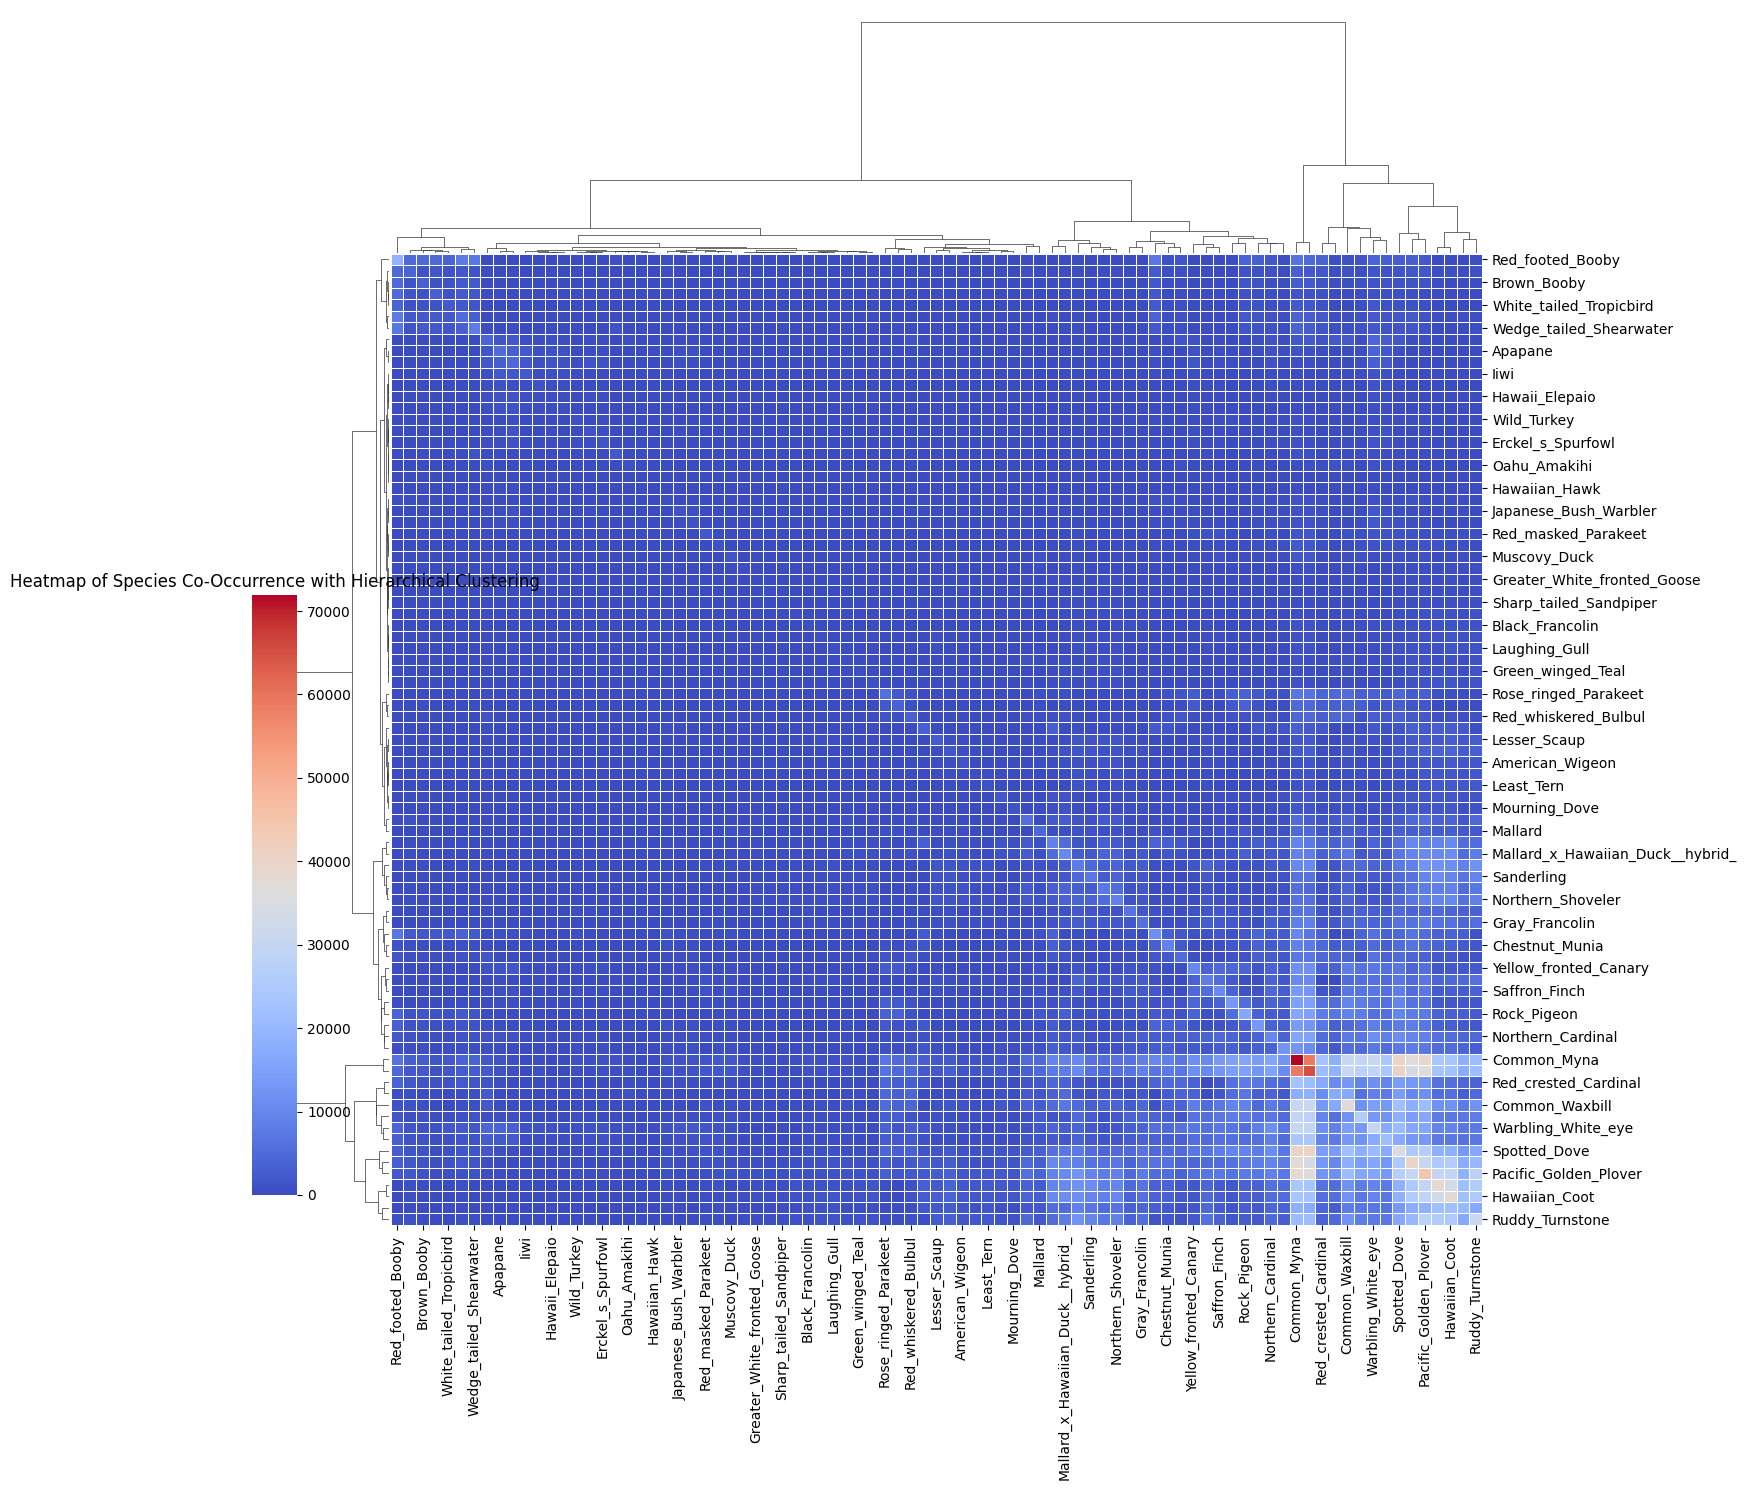

In [ ]:
# Correlation with dendrogram

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram



# Transpose the DataFrame
training_set_transposed = training_set.T

# Calculate Co-Occurrence Matrix
# This can be done by dot product since the data is binary (0s and 1s)
co_occurrence_matrix = training_set_transposed.T.dot(training_set_transposed)

# Hierarchical Clustering
linkage_matrix = linkage(co_occurrence_matrix, method='ward')

# Create a heatmap with dendrograms
sns.clustermap(co_occurrence_matrix,
               method='ward',
               cmap='coolwarm',
               linewidths=.5,
               figsize=(15, 15),
               dendrogram_ratio=(.1, .2),
               cbar_pos=(0, .2, .03, .4))

plt.title('Heatmap of Species Co-Occurrence with Hierarchical Clustering')
plt.show()


The heatmap is an overlay of hierarchical clustering, presenting an analysis of species co-occurrence within the given dataset. The heatmap's color gradient, transitioning from blue to red, quantitatively illustrates the frequency with which pairs of species have been observed together; red denotes a higher frequency of co-occurrence, whereas blue signifies a lower one. This pattern indicates the likelihood of interspecies interactions or shared habitat preferences.

Accompanying the heatmap, the dendrogram reveals the results of the hierarchical clustering analysis. It categorizes species into clusters based on the similarity of their observation patterns. The hierarchical nature of the dendrogram allows us to perceive not only which species are frequently observed together but also how these species groups relate to one another. Longer branches between nodes suggest a lower degree of similarity between species clusters, while shorter branches indicate closer relationships.

From an ecological standpoint, the analysis could be indicative of underlying biological or environmental factors influencing species distribution. Species that cluster closely may share ecological niches or may be part of the same food chain. Conversely, those that are distantly related in the dendrogram might inhabit separate ecological zones or operate at different trophic levels. This visual and analytical tool is pivotal for ecologists to hypothesize about community structures and to guide further, more detailed investigations into the ecological dynamics of the species under observation.

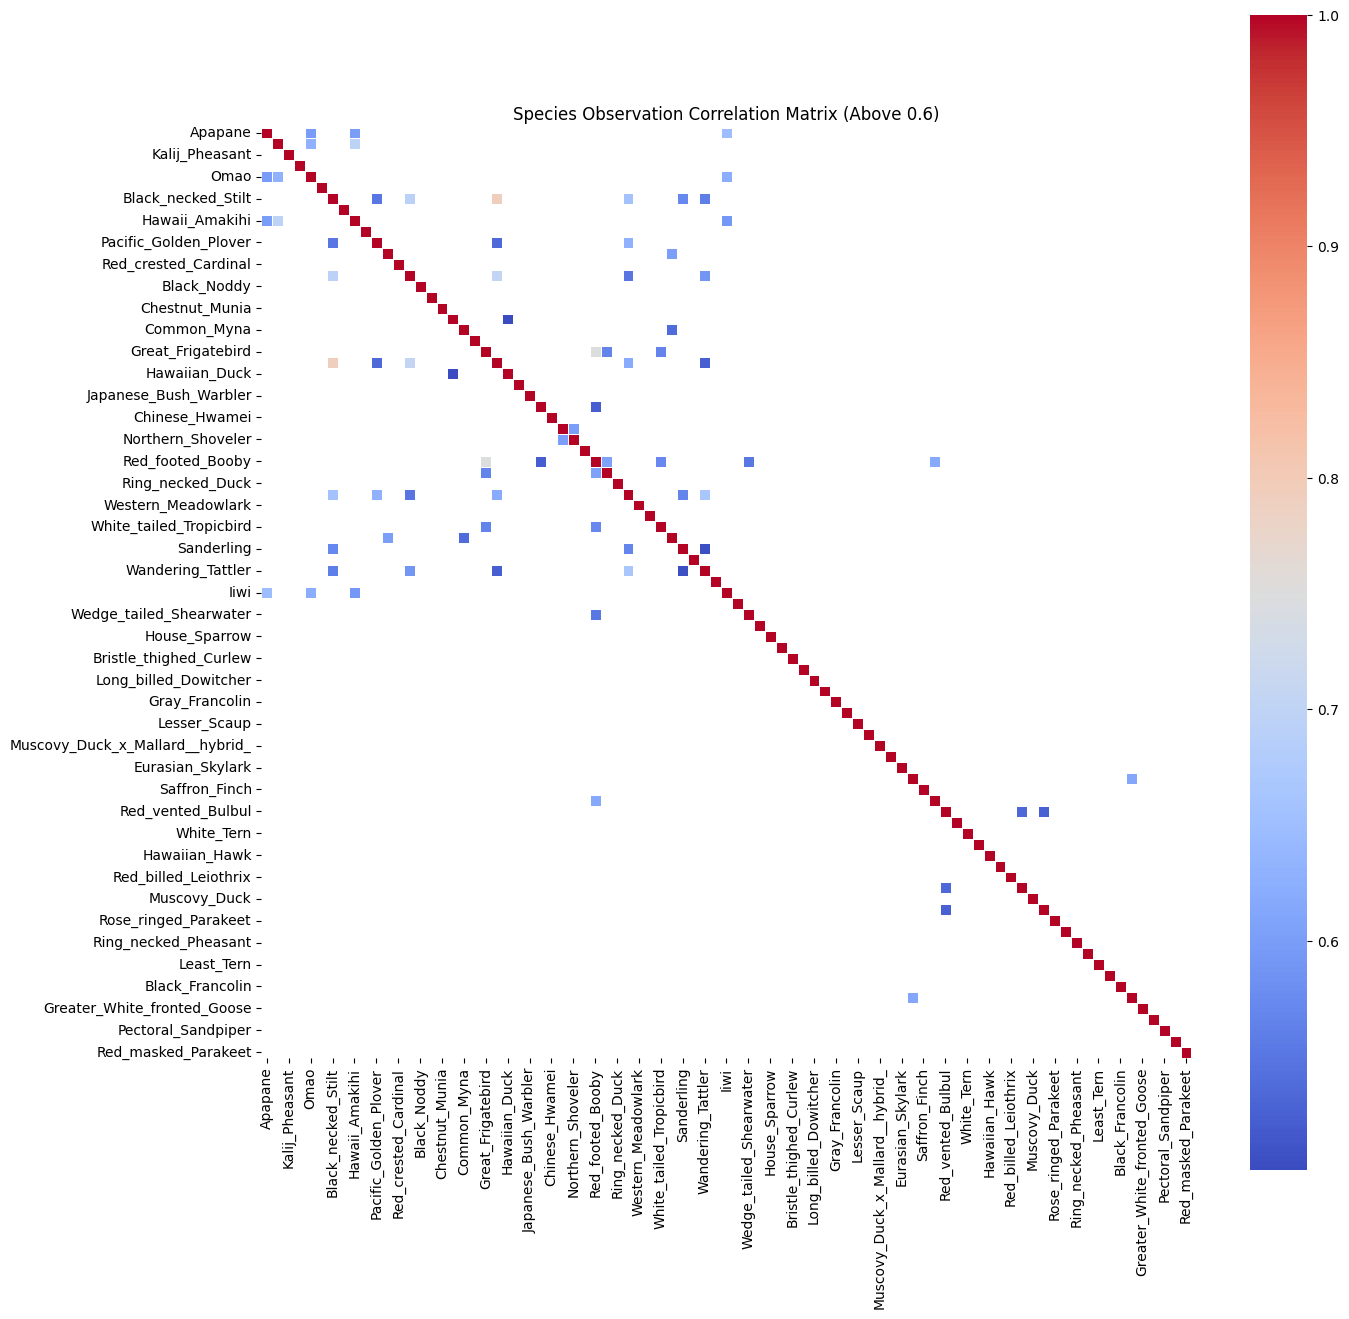

In [ ]:
# Filtered correlation matrix

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# Transpose the DataFrame so that each column represents a species and each row is a checklist
training_set_transposed = training_set.T

# Calculate the correlation matrix
correlation_matrix = training_set_transposed.corr()

# Filter the correlation matrix to only show correlations above 0.6
correlation_matrix_filtered = correlation_matrix.where(correlation_matrix > 0.5, np.nan)

# Create a heatmap to visualize the filtered correlation matrix
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix_filtered,
            annot=False,      # Set to True if you want to see the correlation values
            cmap='coolwarm',  # Choose a color map that you prefer
            linewidths=.5,    # Adjust line widths between cells
            fmt=".2f",        # Formatting for annotation strings
            square=True)      # Make cells square shaped

plt.title('Species Observation Correlation Matrix (Above 0.6)')
plt.show()


The heatmap is a species observation correlation matrix that has been filtered to display only correlation coefficients above 0.6. This visualization method emphasizes the most significant positive correlations among species, offering a clear perspective on which species pairs have strong positive relationships in terms of co-occurrence.

The color gradient from blue to red indicates the strength of the correlation, with darker red squares representing stronger positive correlations. These highlighted squares suggest a high likelihood of co-occurrence, which could be due to similar ecological niches, mutualistic relationships, or shared environmental preferences.

The exclusion of lower correlation coefficients helps to avoid visual clutter, directing attention to the most ecologically relevant associations. This focused approach aids in identifying key species pairs that may warrant further ecological investigation or conservation efforts. It also simplifies the interpretation of complex ecological data, making the plot more accessible for both experts and non-specialists.

The diagonal line of dark red squares represents the perfect correlation of species with themselves, which is a standard feature of correlation matrices. Outside of this diagonal, the significant correlations indicated by the red squares are of particular interest, as they could represent potential areas of focus for ecological research, such as understanding community structures, species interactions, or the impact of environmental changes on these relationships.







Building on the insights gleaned from the heatmap analysis, we curated a list of species pairs that exhibit a high degree of co-occurrence based on their correlation coefficients surpassing the 0.6 threshold. This selection of strongly correlated species served as the basis for developing tailored weights within our KNN model, with the aim of enhancing the model's predictive accuracy by emphasizing the influence of these significant species interactions.

In [ ]:
# Calculate the correlation matrix
correlation_matrix = training_set_transposed.corr()

# Filter the correlation matrix to only show correlations above 0.5
correlation_matrix_filtered = correlation_matrix.where(correlation_matrix > 0.5, np.nan)

# Initialize an empty list to store species pairs
highly_correlated_pairs = []

# Iterate over the matrix and collect names of highly correlated species
for row in correlation_matrix_filtered.index:
    for col in correlation_matrix_filtered.columns:
        if pd.notna(correlation_matrix_filtered.loc[row, col]) and row != col:
            highly_correlated_pairs.append((row, col))

# Print or process the species pairs
for pair in highly_correlated_pairs:
    print(pair)

('Apapane', 'Omao')
('Apapane', 'Hawaii_Amakihi')
('Apapane', 'Iiwi')
('Hawaii_Elepaio', 'Omao')
('Hawaii_Elepaio', 'Hawaii_Amakihi')
('Omao', 'Apapane')
('Omao', 'Hawaii_Elepaio')
('Omao', 'Iiwi')
('Black_necked_Stilt', 'Pacific_Golden_Plover')
('Black_necked_Stilt', 'Black_crowned_Night_Heron')
('Black_necked_Stilt', 'Hawaiian_Coot')
('Black_necked_Stilt', 'Ruddy_Turnstone')
('Black_necked_Stilt', 'Sanderling')
('Black_necked_Stilt', 'Wandering_Tattler')
('Hawaii_Amakihi', 'Apapane')
('Hawaii_Amakihi', 'Hawaii_Elepaio')
('Hawaii_Amakihi', 'Iiwi')
('Pacific_Golden_Plover', 'Black_necked_Stilt')
('Pacific_Golden_Plover', 'Hawaiian_Coot')
('Pacific_Golden_Plover', 'Ruddy_Turnstone')
('Spotted_Dove', 'Zebra_Dove')
('Black_crowned_Night_Heron', 'Black_necked_Stilt')
('Black_crowned_Night_Heron', 'Hawaiian_Coot')
('Black_crowned_Night_Heron', 'Ruddy_Turnstone')
('Black_crowned_Night_Heron', 'Wandering_Tattler')
('Common_Gallinule', 'Hawaiian_Duck')
('Common_Myna', 'Zebra_Dove')
('Great_Fri

In [ ]:
# Cosine Similarity with correlated matrix code that we used


# Calculate the correlation matrix
correlation_matrix = training_set_transposed.corr()

# Get the indices of the upper triangle of the matrix, excluding the diagonal
rows, cols = np.triu_indices(len(correlation_matrix), k=1)

# Initialize an empty list to store species pairs
highly_correlated_pairs = []

# Iterate over the upper triangle
for row, col in zip(rows, cols):
    if correlation_matrix.iloc[row, col] > 0.5:
        highly_correlated_pairs.append((correlation_matrix.index[row], correlation_matrix.columns[col]))

#Apply log transformation
training_set_log = np.log1p(training_set_transposed)
test_set_log = np.log1p(test_set_df)

# After defining training_set_log
species_to_index = {species: i for i, species in enumerate(training_set_log.columns)}


#Calculate the frequency of observation for each species
observation_frequencies = training_set_log.apply(lambda x: np.count_nonzero(x), axis=1)

#Normalize the frequencies
max_frequency = observation_frequencies.max()
normalized_frequencies = observation_frequencies / max_frequency
# Ensure that A_transposed has species as rows and features as columns
A_transposed = training_set_log


# Adjust the KNN function
def recommend_by_knn_cosine(A, x, K, correlated_pairs, species_to_index):
    adjusted_weights = normalized_frequencies.copy()

    # Check if x is a 1D array and reshape only if necessary
    x_reshaped = x.reshape(1, -1) if x.ndim == 1 else x

    for species1, species2 in correlated_pairs:
        idx1 = species_to_index[species1]
        idx2 = species_to_index[species2]

        # Check if the original x (before reshaping) has the species1
        if x.flatten()[idx1] > 0:
            adjusted_weights[idx2] *= 0.5

    # Calculate cosine similarity
    A_transposed = A.T
    cos_sim = cosine_similarity(A_transposed, x_reshaped)

    # Get indices of K most similar neighbors
    nearest_indices = np.argsort(-cos_sim.flatten())[:K]

    # Select K nearest neighbors using .iloc for proper indexing from A (not A_transposed)
    nearest_neighbors = A.iloc[:, nearest_indices]
    # Use the cosine similarity as weights
    cosine_weights = cos_sim.flatten()[nearest_indices]

    # Generate recommendations based on the weighted sum of the neighbors' presence
    weighted_sum = np.dot(nearest_neighbors, cosine_weights)

    # Generate recommendations
    recommendations = np.zeros(len(x))
    top_indices = np.argsort(-weighted_sum)[:5]  # Select top 5 recommendations
    recommendations[top_indices] = 1

    return recommendations



Unfortunately, the above application of the highly correlated species as weights did not improve the model's performance.

### Other Distance Metrics
#### Some other distance metrics that we tried are as follows:

#### Minkowski



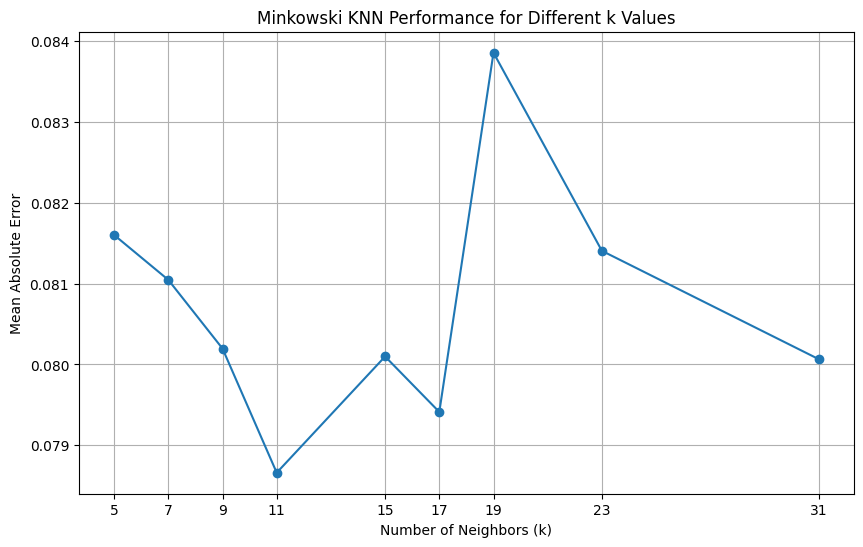

In [ ]:
# Minkowski distance metric

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import random

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Load the training set


# Convert the training set to numpy array and apply log transformation
training_set_log = np.log1p(training_set.to_numpy())


def recommend_by_minkowski_nn(A, x, p):
    # Calculate Minkowski distance between vector x and each column in A
    distances = np.sum(np.abs(A - x[:, None])**p, axis=0)**(1/p)

    # Select the nearest neighbor based on Minkowski difference
    training_nn = A[:, np.argmin(distances)]

    # Don't recommend any values which are non-zero in the test sample
    training_nn[x != 0] = 0

    # Generate 5 recommendations
    recommendations = np.zeros(len(x))

    # Select the top 5 non-zeros in "training_nn" that are zero in "x"
    # and set them equal to 1
    top_indices = np.argsort(-training_nn)[:5]
    recommendations[top_indices] = 1

    return recommendations



  # Define a function to simulate the test data as described
def simulate_test_data(test_data):
    simulated_data = test_data.copy()
    standard_data = np.zeros_like(test_data)
    for i in range(simulated_data.shape[1]):
        non_zero_indices = np.where(simulated_data[:, i] != 0)[0]
        if len(non_zero_indices) > 5:
            zero_indices = np.random.choice(non_zero_indices, 5, replace=False)
            simulated_data[zero_indices, i] = 0
            standard_data[zero_indices, i] = 1
    return simulated_data, standard_data


# Define the number of folds and k values to test
n_splits = 10
k_values = [5, 7, 9, 11, 15, 17, 19, 23,31]  # Example k values, adjust as necessary

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Dictionary to store average MAE for each k
mae_per_k = {}  # Correct variable to store the MAE for each k

# Loop over each 'K' value
for K in k_values:
    performances = []
    all_predictions = []  # List to store all predictions for this K

    # Perform K-Fold Cross Validation
    for train_index, val_index in kf.split(training_set_log):
        train_data = training_set_log[:, train_index]
        val_data = training_set_log[:, val_index]

        # Simulate the test data
        simulated_data, standard_data = simulate_test_data(val_data)

        # Apply the KNN model to each sample in simulated_test_data
        predictions = np.apply_along_axis(lambda x: recommend_by_minkowski_nn(train_data, x, K), axis=0, arr=simulated_data)

        # Store predictions
        all_predictions.extend(predictions)  # Use extend instead of append to flatten the list of arrays

        # Compute the performance metric against the original test data
        mae = mean_absolute_error(standard_data, predictions)
        performances.append(mae)

    # Store the average MAE for this K value in the dictionary
    mae_per_k[K] = np.mean(performances)  # Store the average MAE, not the predictions

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(list(mae_per_k.keys()), list(mae_per_k.values()), marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Absolute Error')
plt.title('Minkowski KNN Performance for Different k Values')
plt.xticks(k_values)
plt.grid(True)
plt.show()




####Euclidean

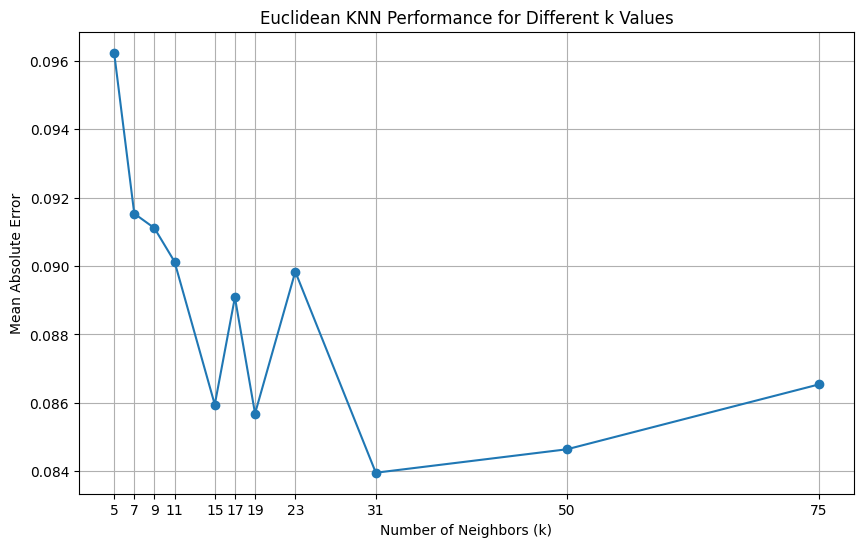

In [ ]:
# Euclidean distance metric
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import random


# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Load the training set


# Convert the training set to numpy array and apply log transformation
training_set_log = np.log1p(training_set.to_numpy())

def recommend_by_euclidean_knn(A, x, K):
    # Transpose A to match the shape with x for broadcasting
    A_transposed = A.T

    # Calculate Euclidean distances without weights
    distances = np.sqrt(np.sum((A_transposed - x) ** 2, axis=1))

    # Get indices of K nearest neighbors
    nearest_indices = np.argsort(distances)[:K]

    # Select K nearest neighbors
    nearest_neighbors = A[:, nearest_indices]

    # Average of K nearest neighbors
    average_neighbors = np.mean(nearest_neighbors, axis=1)

    # Generate recommendations
    recommendations = np.zeros(len(x))
    top_indices = np.argsort(-average_neighbors)[:5]  # Select top 5 recommendations
    recommendations[top_indices] = 1

    return recommendations


  # Define a function to simulate the test data as described
def simulate_test_data(test_data):
    simulated_data = test_data.copy()
    standard_data = np.zeros_like(test_data)
    for i in range(simulated_data.shape[1]):
        non_zero_indices = np.where(simulated_data[:, i] != 0)[0]
        if len(non_zero_indices) > 5:
            zero_indices = np.random.choice(non_zero_indices, 5, replace=False)
            simulated_data[zero_indices, i] = 0
            standard_data[zero_indices, i] = 1
    return simulated_data, standard_data


# Define the number of folds and k values to test
n_splits = 10
k_values = [5, 7, 9, 11, 15, 17, 19, 23, 31, 50, 75]

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Dictionary to store average MAE for each k
mae_per_k = {}


# Loop over each 'K' value
for K in k_values:
    performances = []
    all_predictions = []  # List to store all predictions for this K

    # Perform K-Fold Cross Validation
    for train_index, val_index in kf.split(training_set_log):
        train_data = training_set_log[:, train_index]
        val_data = training_set_log[:, val_index]

        # Simulate the test data
        simulated_data, standard_data = simulate_test_data(val_data)

        # Apply the KNN model to each sample in simulated_test_data
        predictions = np.apply_along_axis(lambda x: recommend_by_euclidean_knn(train_data, x, K), axis=0, arr=simulated_data)

        # Store predictions
        all_predictions.extend(predictions)  # Use extend instead of append to flatten the list of arrays

        # Compute the performance metric against the original test data
        mae = mean_absolute_error(standard_data, predictions)
        performances.append(mae)

    # Store the average MAE for this K value in the dictionary
    mae_per_k[K] = np.mean(performances)  # Store the average MAE, not the predictions

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(list(mae_per_k.keys()), list(mae_per_k.values()), marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Absolute Error')
plt.title('Euclidean KNN Performance for Different k Values')
plt.xticks(k_values)
plt.grid(True)
plt.show()




#### Euclidean distance metric with frequency as weights

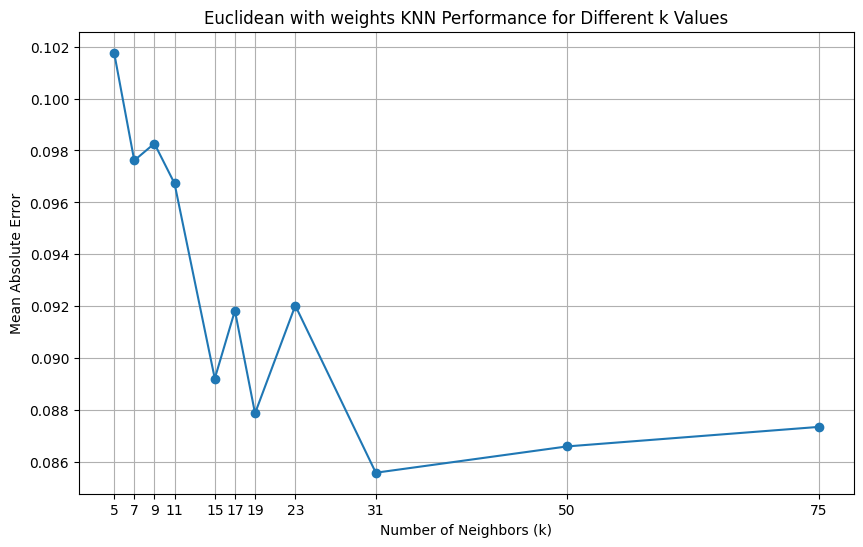

In [ ]:
# Euclidean distance metric with frequency as weights
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import random


# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Load the training set

# Calculate the frequency of observation for each species (row-wise)
observation_frequencies = np.count_nonzero(training_set, axis=1)

# Normalize the frequencies
max_frequency = observation_frequencies.max()
normalized_frequencies = observation_frequencies / max_frequency


# Convert the training set to numpy array and apply log transformation
training_set_log = np.log1p(training_set.to_numpy())

def recommend_by_euclidean_knn(A, x, K, freq_weights):
    # Transpose A to match the shape with x for broadcasting
    A_transposed = A.T

    # Calculate squared weighted Euclidean distances
    squared_diff = (A_transposed - x) ** 2
    weighted_squared_diff = squared_diff * freq_weights
    distances = np.sqrt(np.sum(weighted_squared_diff, axis=1))

    # Get indices of K nearest neighbors
    nearest_indices = np.argsort(distances)[:K]

    # Select K nearest neighbors
    nearest_neighbors = A[:, nearest_indices]

    # Average of K nearest neighbors instead of weighted sum
    average_neighbors = np.mean(nearest_neighbors, axis=1)

    # Generate recommendations
    recommendations = np.zeros(len(x))
    top_indices = np.argsort(-average_neighbors)[:5]  # Select top 5 recommendations
    recommendations[top_indices] = 1

    return recommendations


  # Define a function to simulate the test data as described
def simulate_test_data(test_data):
    simulated_data = test_data.copy()
    standard_data = np.zeros_like(test_data)
    for i in range(simulated_data.shape[1]):
        non_zero_indices = np.where(simulated_data[:, i] != 0)[0]
        if len(non_zero_indices) > 5:
            zero_indices = np.random.choice(non_zero_indices, 5, replace=False)
            simulated_data[zero_indices, i] = 0
            standard_data[zero_indices, i] = 1
    return simulated_data, standard_data


# Define the number of folds and k values to test
n_splits = 10
k_values = [5, 7, 9, 11, 15, 17, 19, 23, 31, 50, 75]

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Dictionary to store average MAE for each k
mae_per_k = {}


# Loop over each 'K' value
for K in k_values:
    performances = []
    all_predictions = []  # List to store all predictions for this K

    # Perform K-Fold Cross Validation
    for train_index, val_index in kf.split(training_set_log):
        train_data = training_set_log[:, train_index]
        val_data = training_set_log[:, val_index]

        # Simulate the test data
        simulated_data, standard_data = simulate_test_data(val_data)

        # Apply the KNN model to each sample in simulated_test_data
        predictions = np.apply_along_axis(lambda x: recommend_by_euclidean_knn(train_data, x, K, normalized_frequencies), axis=0, arr=simulated_data)

        # Store predictions
        all_predictions.extend(predictions)  # Use extend instead of append to flatten the list of arrays

        # Compute the performance metric against the original test data
        mae = mean_absolute_error(standard_data, predictions)
        performances.append(mae)

    # Store the average MAE for this K value in the dictionary
    mae_per_k[K] = np.mean(performances)  # Store the average MAE, not the predictions

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(list(mae_per_k.keys()), list(mae_per_k.values()), marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Absolute Error')
plt.title('Euclidean with weights KNN Performance for Different k Values')
plt.xticks(k_values)
plt.grid(True)
plt.show()


#### Manhattan

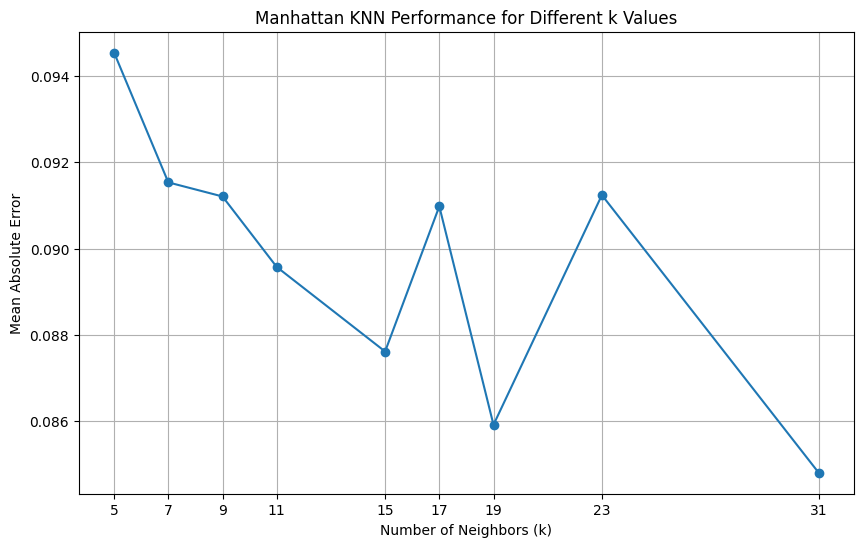

In [ ]:
# Manhattan with weights

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import random

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Load the training set


# Convert the training set to numpy array and apply log transformation
training_set_log = np.log1p(training_set.to_numpy())



def recommend_by_weighted_knn(A, x, K):
    # Define weights for Manhattan distance calculation
    manhattan_weights = np.ones(A.shape[0])  # Assuming equal weights for all features

    # Transpose A to match the shape with x for broadcasting
    A_transposed = A.T

    # Calculate Weighted Manhattan distances
    distances = np.sum(manhattan_weights * np.abs(A_transposed - x), axis=1)  # Broadcasting along samples

    # Get indices of K nearest neighbors
    nearest_indices = np.argsort(distances)[:K]

    # Select K nearest neighbors
    nearest_neighbors = A[:, nearest_indices]

    # Compute inverse distance weights (avoid division by zero)
    # These are different weights used for the weighted sum of neighbors
    inverse_distance_weights = 1 / (distances[nearest_indices] + 1e-10)

    # Weighted sum of K nearest neighbors
    weighted_sum = np.dot(nearest_neighbors, inverse_distance_weights)

    # Generate recommendations
    recommendations = np.zeros(len(x))
    top_indices = np.argsort(-weighted_sum)[:5]  # Select top 5 recommendations
    recommendations[top_indices] = 1

    return recommendations


  # Define a function to simulate the test data as described
def simulate_test_data(test_data):
    simulated_data = test_data.copy()
    standard_data = np.zeros_like(test_data)
    for i in range(simulated_data.shape[1]):
        non_zero_indices = np.where(simulated_data[:, i] != 0)[0]
        if len(non_zero_indices) > 5:
            zero_indices = np.random.choice(non_zero_indices, 5, replace=False)
            simulated_data[zero_indices, i] = 0
            standard_data[zero_indices, i] = 1
    return simulated_data, standard_data


# Define the number of folds and k values to test
n_splits = 10
k_values = [5, 7, 9, 11, 15, 17, 19, 23,31]  # Example k values, adjust as necessary

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Dictionary to store average MAE for each k
mae_per_k = {}  # Correct variable to store the MAE for each k

# Loop over each 'K' value
for K in k_values:
    performances = []
    all_predictions = []  # List to store all predictions for this K

    # Perform K-Fold Cross Validation
    for train_index, val_index in kf.split(training_set_log):
        train_data = training_set_log[:, train_index]
        val_data = training_set_log[:, val_index]

        # Simulate the test data
        simulated_data, standard_data = simulate_test_data(val_data)

        # Apply the KNN model to each sample in simulated_test_data
        predictions = np.apply_along_axis(lambda x: recommend_by_weighted_knn(train_data, x, K), axis=0, arr=simulated_data)

        # Store predictions
        all_predictions.extend(predictions)  # Use extend instead of append to flatten the list of arrays

        # Compute the performance metric against the original test data
        mae = mean_absolute_error(standard_data, predictions)
        performances.append(mae)

    # Store the average MAE for this K value in the dictionary
    mae_per_k[K] = np.mean(performances)  # Store the average MAE, not the predictions

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(list(mae_per_k.keys()), list(mae_per_k.values()), marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Absolute Error')
plt.title('Manhattan KNN Performance for Different k Values')
plt.xticks(k_values)
plt.grid(True)
plt.show()




#### Chebyshev

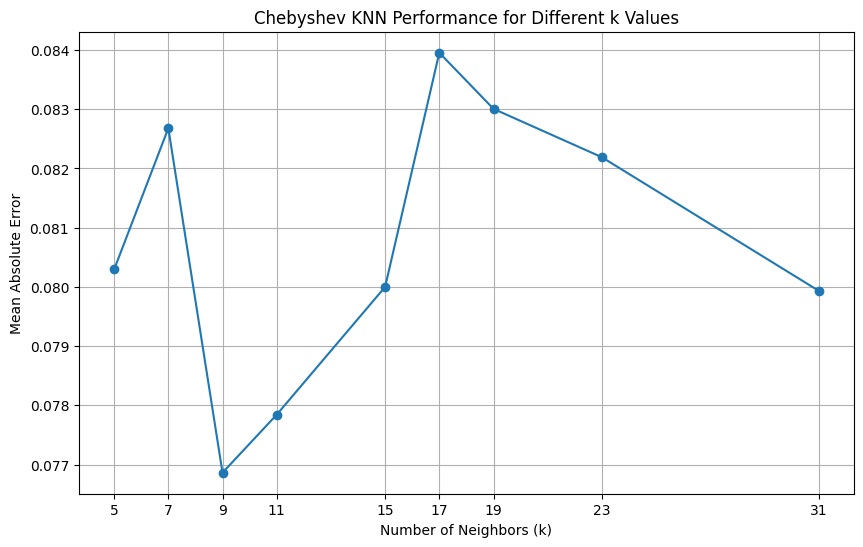

In [ ]:

# Chebyshev distance metric

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import random

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Load the training set


# Convert the training set to numpy array and apply log transformation
training_set_log = np.log1p(training_set.to_numpy())



# Define your KNN function outside the loop
def recommend_by_chebyshev_nn(A, x, k):
    # Calculate Chebyshev distance between vector x and each column in A
    distances = np.array([np.max(np.abs(x - col)) for col in A.T])

    # Select the nearest neighbor based on Chebyshev distance
    training_nn = A[:, np.argmin(distances)]

    # Don't recommend any values which are non-zero in the test sample
    training_nn[x != 0] = 0

    # Generate 5 recommendations
    recommendations = np.zeros(len(x))

    # Select the top 5 non-zeros in "training_nn" that are zero in "x"
    # and set them equal to 1
    top_indices = np.argsort(-training_nn)[:5]
    recommendations[top_indices] = 1

    return recommendations


# Define a function to simulate the test data as described
def simulate_test_data(test_data):
    simulated_data = test_data.copy()
    standard_data = np.zeros_like(test_data)
    for i in range(simulated_data.shape[1]):
        non_zero_indices = np.where(simulated_data[:, i] != 0)[0]
        if len(non_zero_indices) > 5:
            zero_indices = np.random.choice(non_zero_indices, 5, replace=False)
            simulated_data[zero_indices, i] = 0
            standard_data[zero_indices, i] = 1
    return simulated_data, standard_data


# Define the number of folds and k values to test
n_splits = 10
k_values = [5, 7, 9, 11, 15, 17, 19, 23,31]  # Example k values, adjust as necessary

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Dictionary to store average MAE for each k
mae_per_k = {}  # Correct variable to store the MAE for each k

# Loop over each 'K' value
for K in k_values:
    performances = []
    all_predictions = []  # List to store all predictions for this K

    # Perform K-Fold Cross Validation
    for train_index, val_index in kf.split(training_set_log):
        train_data = training_set_log[:, train_index]
        val_data = training_set_log[:, val_index]

        # Simulate the test data
        simulated_data, standard_data = simulate_test_data(val_data)

        # Apply the KNN model to each sample in simulated_test_data
        predictions = np.apply_along_axis(lambda x: recommend_by_chebyshev_nn(train_data, x, K), axis=0, arr=simulated_data)

        # Store predictions
        all_predictions.extend(predictions)  # Use extend instead of append to flatten the list of arrays

        # Compute the performance metric against the original test data
        mae = mean_absolute_error(standard_data, predictions)
        performances.append(mae)

    # Store the average MAE for this K value in the dictionary
    mae_per_k[K] = np.mean(performances)  # Store the average MAE, not the predictions

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(list(mae_per_k.keys()), list(mae_per_k.values()), marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Absolute Error')
plt.title('Chebyshev KNN Performance for Different k Values')
plt.xticks(k_values)
plt.grid(True)
plt.show()




## Results

After experimenting with various distance metrics, we found that Cosine similarity was the better fit since the MAE values for all values of k in the cross-validation were fairly lower than in the other distance metrics.


#### Why did we choose cosine similarity to find the nearest neighbors?

Han et al (2022) in their book "Data Mining Concepts and Techniques" recommends cosine similarity to measure data that consists of thousands of features that are very long and sparse (i.e., they have many 0 values) since traditional distance measures like Manhattan and Euclidean do not work well with sparse numeric data.Based on the structure of both the training and test data we can see their features exhibit the same characteristics hence our decision to use cosine similarity.

## Conclusion



In conclusion, the implementation of a Bird Recommender System using the K-Nearest Neighbors (KNN) algorithm marks a pivotal enhancement in the accuracy and completeness of the eBird dataset's bird species observations submitted by citizen scientists. This system addresses missing data issues effectively, thereby improving the global bird observation database's quality.

The development process, from detailed data preprocessing to the use of varied distance metrics such as Chebyshev and cosine similarity, showcases the complexity and depth of understanding necessary for creating a dependable recommendation tool. These methodologies were specifically chosen to suit the unique aspects of the dataset, emphasizing the importance of a nuanced approach.

A key challenge in this project was determining the optimal k-value for the KNN model. Despite our cross-validation algorithm's suggestion, there was a discrepancy between the proposed k-value and the actual k-value that proved most effective in practice. This discrepancy underscores the critical nature of selecting an appropriate k-value to prevent overfitting or underfitting, ensuring the model's predictions remain accurate and reliable.

To improve the current model's precision in the Bird Recommender System, exploring advanced machine learning models and integrating diverse data sources are promising avenues:

Advanced Machine Learning Models: Investigating models beyond KNN, such as Random Forests, Gradient Boosting Machines (GBM), or deep learning architectures like Convolutional Neural Networks (CNNs) tailored for pattern recognition in large datasets, could enhance predictive accuracy and handle complex nonlinear relationships.

Feature Engineering: Developing more sophisticated features that capture temporal patterns, geographical information, and ecological variables could provide deeper insights into species distribution and observation likelihoods.

Incorporating Diverse Data: Integrating external datasets, such as weather conditions, habitat information, and migration patterns, could improve the model's ability to predict bird sightings by considering environmental and ecological factors.

Model Ensemble Techniques: Combining predictions from multiple models through ensemble techniques like stacking or blending might yield better accuracy than any single model by leveraging the strengths of diverse approaches.

Hyperparameter Tuning: Rigorous optimization of model parameters using techniques like grid search or Bayesian optimization can fine-tune the model's performance to the specific characteristics of the dataset.

By focusing on these strategies, the Bird Recommender System can achieve higher levels of precision and reliability, further empowering citizen scientists and contributing to the broader goals of research and conservation.